# Notebook overview
Experimental notebook for image square-padding strategies and patch analysis.

- Loads a pretrained DINOv2 model and its preprocessing pipeline
- Implements and compares padding methods: large patches, small blurred patches, and mean-color padding
- Visualizes model patch activations and PCA of patches; shows preprocessing crop results
- Saves example outputs to a results folder for inspection and comparison

### Import

In [25]:
import numpy as np
from pathlib import Path

import timm
import torch

import torch
import torchvision.transforms as T

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image, ImageFilter, ImageDraw

import random

# Funktions

## Functions - Preprocessing

### Function - load_model

In [26]:
def load_model():    
    ### Load the model
    dinov2_vits14 = timm.create_model("vit_small_patch14_dinov2.lvd142m", pretrained=True)
    dinov2_vits14.eval()

    # Patchgröße
    print("Patch-Größe:", dinov2_vits14.patch_embed.patch_size)
    # Eingabegröße (wenn spezifiziert)
    print("Default Eingabegröße:", dinov2_vits14.default_cfg['input_size'])
    # Patch Anzahl - 518 / 14 * 518 / 14 = 1369 Patches
    return dinov2_vits14

In [27]:
### Set device (NICHT GETESTET)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Training on device {device}.")

Training on device cuda.


### Function - load_preprocessing_pipeline

In [28]:
def load_preprocessing_pipeline(model):
    ### Load preprocessing pipeline
    data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
    transform = timm.data.create_transform(**data_cfg)
    print(f"transform pypline: {transform}")
    ### transform settings
    # model.pretrained_cfg
    # data_cfg # is it usefull to do normalisation and if yes on default values
    return transform

### Function - load_patches

In [29]:
def load_patches(image, transform, model):
    image_transformed = transform(image).unsqueeze(0).to(device)
    model = model.to(device)
    output = model.forward_features(image_transformed)
    # image_cls = output[0,0,:]
    image_patches = output[0,1:,:]
    # image_patches.size()
    return image_patches

### Function - preprocessing_crop_only 

In [30]:
# transform tensor back to normal image
def preprocessing_crop_only(image):
    image_transformed = transform(image).unsqueeze(0).to(device)

    # Prepear transformed image to [3, 518, 518]
    image_tensor = image_transformed.squeeze(0).cpu()

    # Reversal of normalization
    mean = torch.tensor([0.4850, 0.4560, 0.4060])
    std = torch.tensor([0.2290, 0.2240, 0.2250])
    image_unorm = image_tensor * std[:, None, None] + mean[:, None, None] # None creates new dimension 1
    # tensor([[[0.2290]],
    #        [[0.2240]],
    #        [[0.2250]]])

    # Clipping auf [0, 1] (some values may be outside the range due to normalization)
    image_unorm = torch.clamp(image_unorm, 0, 1)

    # Tensor zu PIL-Bild
    to_pil = T.ToPILImage()
    image_transformed_back = to_pil(image_unorm)

    # Anzeige
    # plt.figure(figsize=(10, 8))
    # plt.imshow(image_transformed_back)
    # plt.axis("off")
    # plt.show()
    return image_transformed_back

## Functions - PCA

### Function - visualize_first_pca

In [31]:
# ATTENTIONE - ADAPTED Function - returns predicted pca sign
def visualize_first_pca(img_patches, save_path):
    img_pca = extract_first_pca(img_patches)
    img_pca_squeeze = img_pca.squeeze()
    img_pca_squeeze_resape = img_pca_squeeze.reshape(37,37)
    
    fig, ax = plt.subplots()
    image_pca = ax.imshow(img_pca_squeeze_resape, cmap='coolwarm')
    plt.colorbar(image_pca, ax=ax, fraction=0.046, pad=0.04)
    plt.axis('off')
    plt.savefig( save_path)
    plt.show()
    return plt


def extract_first_pca(img_patches):
    pca1 = PCA(1)
    pca_proj = pca1.fit_transform(img_patches.detach().cpu())
    print(pca_proj.shape)
    return pca_proj

# example
# load_patches_12 = load_patches(test_high_images_species_22[12], transform, model)
# visualize_first_pca(load_patches_12, 0.2)

## Functions - resizing

### Function - square_padding_small_blur_patches

In [32]:
def square_padding_small_blur_patches(img_path, output_path=None, patch_size=16, blur_radius=3):
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    
    random.seed(42)
    if w == h:
        if output_path:
            img.save(output_path)
        return img

    size = max(w, h)
    canvas = Image.new("RGB", (size, size))
    random.seed(42)
    # 1. Fill textured canvas
    for y in range(0, size, patch_size):
        for x in range(0, size, patch_size):
            src_x = random.randint(0, max(0, w - patch_size))
            src_y = random.randint(0, max(0, h - patch_size))
            patch = img.crop((src_x, src_y, src_x + patch_size, src_y + patch_size))
            patch = patch.filter(ImageFilter.GaussianBlur(radius=1))  # smooth locally
            canvas.paste(patch, (x, y))

    # 2. Create a copy for soft focus
    blurred_canvas = canvas.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    # 3. Create mask: white background, black rectangle for original image area
    mask = Image.new("L", (size, size), color=255)
    draw = ImageDraw.Draw(mask)
    offset = ((size - w) // 2, (size - h) // 2)
    draw.rectangle(
        [offset[0], offset[1], offset[0] + w, offset[1] + h],
        fill=0
    )

    # 4. Combine soft-focus canvas with original texture using the mask
    softened_bg = Image.composite(blurred_canvas, canvas, mask)

    # 5. Insert the sharp original image
    softened_bg.paste(img, offset)

    if output_path:
        softened_bg.save(output_path)

    return softened_bg


### Function - square_padding_large_patches

In [33]:
# ATENTIONE - FUNCTION make_square_with_texture_padding ADDAPTED 
def square_padding_large_patches(img_path, output_path=None):
    img = Image.open(img_path).convert("RGB")
    w, h = img.size

    if w == h:
        if output_path:
            img.save(output_path)
        return img

    size = max(w, h)
    patch_size = size//3

    canvas = Image.new("RGB", (size, size))
    random.seed(42)
    for y in range(0, size, patch_size):
        for x in range(0, size, patch_size):
            # Random patch position in the original image
            src_x = random.randint(0, max(0, w - patch_size))
            src_y = random.randint(0, max(0, h - patch_size))

            patch = img.crop((src_x, src_y, src_x + patch_size, src_y + patch_size))

            canvas.paste(patch, (x, y))

    # Insert original image centered
    offset = ((size - w) // 2, (size - h) // 2)
    canvas.paste(img, offset)

    if output_path:
        canvas.save(output_path)

    return canvas

### Function - square_padding_mean (mean color)

In [34]:
def square_padding_mean(img_path, output_path=None):
    # Load image
    img = Image.open(img_path).convert("RGB")
    w, h = img.size

    # If square: optionally save directly
    if w == h:
        if output_path:
            img.save(output_path)
        return img

    # Calculate average color (across all pixels and channels)
    img_np = np.array(img)
    mean_color = tuple(np.mean(img_np.reshape(-1, 3), axis=0).astype(np.uint8))

    # New square canvas
    size = max(w, h)
    new_img = Image.new("RGB", (size, size), mean_color)

    # Insert original image centered
    offset = ((size - w) // 2, (size - h) // 2)
    new_img.paste(img, offset)

    if output_path:
        new_img.save(output_path)

    return new_img

# Apply

## Setup

### load  - model, preprocessing pipeline

In [35]:
model = load_model()
transform = load_preprocessing_pipeline(model)

Patch-Größe: (14, 14)
Default Eingabegröße: (3, 518, 518)
transform pypline: Compose(
    Resize(size=518, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(518, 518))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


### Preperation

In [36]:
PATH_SOURCE_IMG = r'/home/stud/jleick/masterArbeitProjekt/final_release/data/images/copied/low/fgrained-2996.png'
PATH_SOURCE_IMG = r'/home/stud/jleick/masterArbeitProjekt/final_release/data/images/copied/low/fgrained-5330.png'
PATH_SOURCE_IMG = r'/home/stud/jleick/masterArbeitProjekt/final_release/data/images/copied/low/fgrained-8621.png'
source_img_path = Path(PATH_SOURCE_IMG)

# source_img_dir_path = source_img_path.parent
dirname = source_img_path.parents[0].name
filename = source_img_path.stem
file_suffix = source_img_path.suffix

RESULT_DIR_PATH = r'/home/stud/jleick/masterArbeitProjekt/final_release/results/test/'
result_dir_path = Path(RESULT_DIR_PATH)
result_dir_path = result_dir_path / dirname
result_dir_path.mkdir(parents=True, exist_ok=True)

## Apply - origin image

#### show origin image

In [37]:
img_origin = Image.open(PATH_SOURCE_IMG).convert("RGB")
img_origin

img_origin.save( result_dir_path / f"{filename}_origin{file_suffix}" )

#### Crop_on_original

In [38]:
img_origin_cropped = preprocessing_crop_only(img_origin)
img_origin_cropped

img_origin_cropped.save( result_dir_path / f"{filename}_croped{file_suffix}" )


#### pca

(1369, 1)


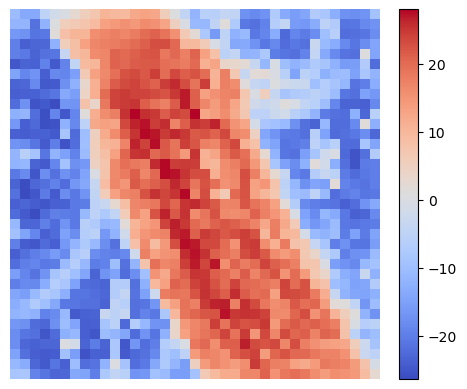

<module 'matplotlib.pyplot' from '/home/stud/jleick/miniconda3/envs/masterArbeit/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [39]:
img_origin_patches = load_patches(img_origin, transform, model)
visualize_first_pca(img_origin_patches, result_dir_path / f"{filename}_cropped_pca{file_suffix}")

## Apply - square_padding_large_patches

#### square_padding_large_patches

In [40]:
img_large = square_padding_large_patches(PATH_SOURCE_IMG, output_path=None)
img_large

img_large.save( result_dir_path / f"{filename}_add_img_parts_large{file_suffix}" )

#### crop

In [41]:
img_large_cropped = preprocessing_crop_only(img_large)
img_large_cropped

img_large_cropped.save( result_dir_path / f"{filename}_add_img_parts_large_cropped{file_suffix}" )

#### pca

(1369, 1)


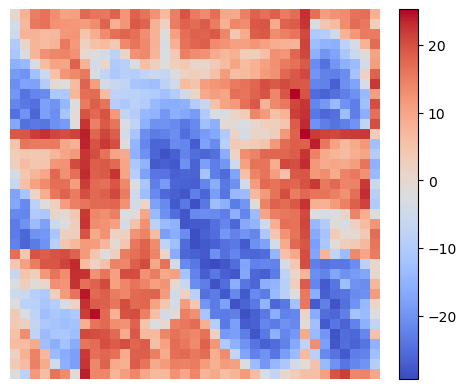

<module 'matplotlib.pyplot' from '/home/stud/jleick/miniconda3/envs/masterArbeit/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [42]:
img_large_patches = load_patches(img_large, transform, model)
visualize_first_pca(img_large_patches, result_dir_path / f"{filename}_add_img_parts_large_pca{file_suffix}")

## Apply - square_padding_small_blur

#### square_padding_small_blur

In [43]:
img_small_blur = square_padding_small_blur_patches(PATH_SOURCE_IMG, output_path=None, patch_size=7, blur_radius=5)
img_small_blur

img_small_blur.save( result_dir_path / f"{filename}_add_img_parts_small_blur{file_suffix}" )

#### crop

In [44]:
img_small_blur_cropped = preprocessing_crop_only(img_small_blur)
img_small_blur_cropped

img_small_blur_cropped.save( result_dir_path / f"{filename}_add_img_parts_small_blur_croped{file_suffix}" )

#### pca

(1369, 1)


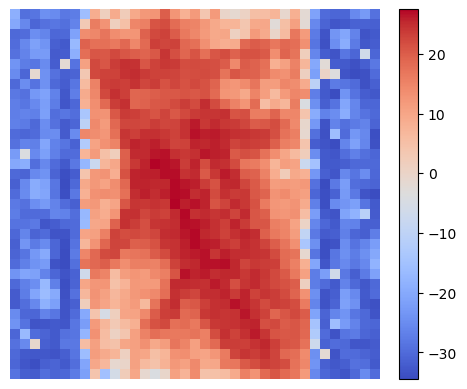

<module 'matplotlib.pyplot' from '/home/stud/jleick/miniconda3/envs/masterArbeit/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [45]:
img_small_blur_patches = load_patches(img_small_blur, transform, model)
visualize_first_pca(img_small_blur_patches, result_dir_path / f"{filename}_add_img_parts_small_blur_pca{file_suffix}")

## Apply - square_padding_mean

#### square_padding_mean

In [46]:
img_mean = square_padding_mean(PATH_SOURCE_IMG)
img_mean

img_mean.save( result_dir_path / f"{filename}_add_img_mean_color{file_suffix}" )

#### crop

In [47]:
img_mean_cropped = preprocessing_crop_only(img_mean)
img_mean_cropped

img_mean_cropped.save( result_dir_path / f"{filename}_add_img_mean_color_croped{file_suffix}" )

#### pca

(1369, 1)


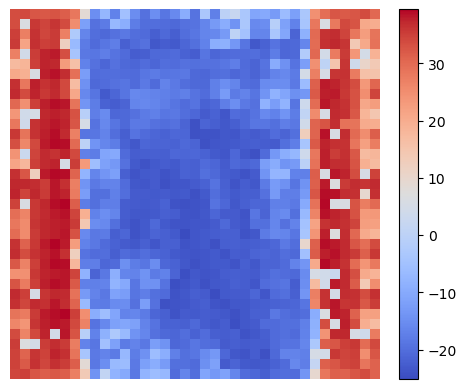

<module 'matplotlib.pyplot' from '/home/stud/jleick/miniconda3/envs/masterArbeit/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [48]:
img_mean_cropped_patches = load_patches(img_mean, transform, model)
visualize_first_pca(img_mean_cropped_patches, result_dir_path / f"{filename}_add_img_mean_color_pca{file_suffix}")